In [1]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm

import gc
import sys
sys.path.append('/home/fcarli/CellHit/')
sys.path.append('/home/fcarli/WebCellHit/webserver_data/')

from parametric_umap import ParametricUMAP

from CellHit.models import EnsembleXGBoost
from CellHit.data import obtain_drugs_metadata
from CellHit.utils import QuantileScoreComputer

import matplotlib.pyplot as plt
import seaborn as sns

from predictions import elaborate_output
from neighbors import FaissKNN, compute_neighbors,add_tcga_metadata,add_ccle_metadata

In [2]:
dataset = 'gdsc'

In [3]:
#sample a syntetic set of data from the alligned TCGA
tdf = pd.read_feather('/home/fcarli/WebCellHit/data/transcriptomics/celligner_CCLE_TCGA_optimized_revised.feather')
tdf = tdf[tdf['index'].str.contains('TCGA-')].sample(100).drop('Source',axis=1).drop_duplicates(subset='index').set_index('index')
tdf.head(3)

,GPR18,GK2,NXF5,AHCYL1,TMOD1,MEGF6,P2RY14,RCC2,XRN1,SIGMAR1,...,BMP4,RBMY1J,FXYD5,STK38,LSM8,ISCA2,IFNL2,INS,DUX4,MKRN3
index,,,,,,,,,,,,,,,,,,,,,
TCGA-GU-A762-01,0.153482,-0.008000,0.038025,-0.890940,-0.042501,1.170514,0.550371,0.304013,-0.029630,-0.970879,...,0.198750,0.011069,0.621236,-0.173664,-1.154853,0.925298,0.175718,0.049862,-0.002001,0.625401
TCGA-FS-A1ZS-06,-0.400331,-0.021116,0.031030,-0.005775,-1.030964,-1.995470,-0.516712,-0.865038,-0.056634,-0.633546,...,-0.352176,-0.003427,0.565630,-1.192534,-0.423893,0.128810,-0.024572,-0.184134,-0.005758,0.701507
TCGA-BH-A8FZ-01,-0.161924,0.003196,-0.120656,0.104925,0.929975,1.307713,1.420849,0.192526,-0.283003,-0.559900,...,-1.148717,-0.027287,1.502729,0.412746,-0.444271,0.082957,0.134060,1.249938,0.081922,2.246350


# Obtain mapping in the UMAP space

In [4]:
umap = ParametricUMAP.load('/home/fcarli/WebCellHit/webserver_data/local_data/umap.trc')
umap_embedding = umap.transform(tdf.values)

/scratch/fcarli/envs/francisCelligner/lib/python3.11/site-packages/parametric_umap/core.py:279: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  save_dict = torch.load(path, ma

# Transcriptomic neighbors

In [5]:
#load ccle neighs
ccle_transcr_neighs = FaissKNN.from_file('/home/fcarli/WebCellHit/webserver_data/local_data/ccle_transcr_neighs.pkl')
tcga_transcr_neighs = FaissKNN.from_file('/home/fcarli/WebCellHit/webserver_data/local_data/tcga_transcr_neighs.pkl')

In [6]:
tdf.head(3)

,GPR18,GK2,NXF5,AHCYL1,TMOD1,MEGF6,P2RY14,RCC2,XRN1,SIGMAR1,...,BMP4,RBMY1J,FXYD5,STK38,LSM8,ISCA2,IFNL2,INS,DUX4,MKRN3
index,,,,,,,,,,,,,,,,,,,,,
TCGA-GU-A762-01,0.153482,-0.008000,0.038025,-0.890940,-0.042501,1.170514,0.550371,0.304013,-0.029630,-0.970879,...,0.198750,0.011069,0.621236,-0.173664,-1.154853,0.925298,0.175718,0.049862,-0.002001,0.625401
TCGA-FS-A1ZS-06,-0.400331,-0.021116,0.031030,-0.005775,-1.030964,-1.995470,-0.516712,-0.865038,-0.056634,-0.633546,...,-0.352176,-0.003427,0.565630,-1.192534,-0.423893,0.128810,-0.024572,-0.184134,-0.005758,0.701507
TCGA-BH-A8FZ-01,-0.161924,0.003196,-0.120656,0.104925,0.929975,1.307713,1.420849,0.192526,-0.283003,-0.559900,...,-1.148717,-0.027287,1.502729,0.412746,-0.444271,0.082957,0.134060,1.249938,0.081922,2.246350


In [7]:
ccle_transcr_neighs_df = ccle_transcr_neighs.knn(tdf,k=1,skip_self=True)
ccle_transcr_neighs_df.rename({'neighbour_point':'ccle_transcr_neigh'},axis=1,inplace=True)
tcga_transcr_neighs_df = tcga_transcr_neighs.knn(tdf,k=1,skip_self=True)
tcga_transcr_neighs_df.rename({'neighbour_point':'tcga_transcr_neigh'},axis=1,inplace=True)

In [8]:
ccle_transcr_neighs_df.head(5)

,query_point,ccle_transcr_neigh,ranking,distance
0,TCGA-GU-A762-01,ACH-000839,0,7011.053711
1,TCGA-FS-A1ZS-06,ACH-000464,0,14284.427734
2,TCGA-BH-A8FZ-01,ACH-000849,0,16183.554688
3,TCGA-CR-7376-01,ACH-000503,0,6210.174805
4,TCGA-FX-A48G-01,ACH-001207,0,16440.169922


In [9]:
tcga_transcr_neighs_df.head(5)

,query_point,tcga_transcr_neigh,ranking,distance
0,TCGA-GU-A762-01,TCGA-FD-A62N-01,0,5429.458008
1,TCGA-FS-A1ZS-06,TCGA-DX-AB2E-01,0,11707.710938
2,TCGA-BH-A8FZ-01,TCGA-A2-A4RY-01,0,7046.025391
3,TCGA-CR-7376-01,TCGA-CR-6492-01,0,3248.118164
4,TCGA-FX-A48G-01,TCGA-IS-A3K8-01,0,10973.025391


In [10]:
transcr_neighs_df = pd.merge(ccle_transcr_neighs_df[['query_point','ccle_transcr_neigh']],tcga_transcr_neighs_df[['query_point','tcga_transcr_neigh']],on='query_point',how='inner')
transcr_neighs_df.head(5)


,query_point,ccle_transcr_neigh,tcga_transcr_neigh
0,TCGA-GU-A762-01,ACH-000839,TCGA-FD-A62N-01
1,TCGA-FS-A1ZS-06,ACH-000464,TCGA-DX-AB2E-01
2,TCGA-BH-A8FZ-01,ACH-000849,TCGA-A2-A4RY-01
3,TCGA-CR-7376-01,ACH-000503,TCGA-CR-6492-01
4,TCGA-FX-A48G-01,ACH-001207,TCGA-IS-A3K8-01


In [11]:
ccle_transcr_annot = add_ccle_metadata(ccle_transcr_neighs_df['ccle_transcr_neigh'],metadata_path='/home/fcarli/WebCellHit/data/metadata/Model.csv')
ccle_transcr_annot.columns = ['ccle_transcr_neigh','ccle_transcr_neigh_name','ccle_transcr_neigh_tissue']
ccle_transcr_annot.head(5)


,ccle_transcr_neigh,ccle_transcr_neigh_name,ccle_transcr_neigh_tissue
0,ACH-000839,SCaBER,Bladder/Urinary Tract
1,ACH-000464,CAS-1,CNS/Brain
2,ACH-000849,MDA-MB-468,Breast
3,ACH-000503,BICR 16,Head and Neck
4,ACH-001207,TIG-3 TD,Fibroblast


In [12]:
tcga_transcr_annot = add_tcga_metadata(tcga_transcr_neighs_df['tcga_transcr_neigh'],metadata_path='/home/fcarli/WebCellHit/data/metadata/tcga_oncotree_data.csv')
tcga_transcr_annot.columns = ['tcga_transcr_neigh','tcga_transcr_neigh_tissue']
tcga_transcr_annot.head(5)


,tcga_transcr_neigh,tcga_transcr_neigh_tissue
0,TCGA-FD-A62N-01,Bladder/Urinary Tract
1,TCGA-DX-AB2E-01,Soft Tissue
2,TCGA-A2-A4RY-01,Breast
3,TCGA-CR-6492-01,Head and Neck
4,TCGA-IS-A3K8-01,Soft Tissue


In [13]:
#merge annotations
transcr_neighs_df = pd.merge(transcr_neighs_df,ccle_transcr_annot,left_on='ccle_transcr_neigh',right_on='ccle_transcr_neigh',how='inner')
transcr_neighs_df = pd.merge(transcr_neighs_df,tcga_transcr_annot,left_on='tcga_transcr_neigh',right_on='tcga_transcr_neigh',how='inner')

#reorder columns
transcr_neighs_df = transcr_neighs_df[['query_point','ccle_transcr_neigh','ccle_transcr_neigh_name','ccle_transcr_neigh_tissue','tcga_transcr_neigh','tcga_transcr_neigh_tissue']]

transcr_neighs_df.head(5)

,query_point,ccle_transcr_neigh,ccle_transcr_neigh_name,ccle_transcr_neigh_tissue,tcga_transcr_neigh,tcga_transcr_neigh_tissue
0,TCGA-GU-A762-01,ACH-000839,SCaBER,Bladder/Urinary Tract,TCGA-FD-A62N-01,Bladder/Urinary Tract
1,TCGA-FS-A1ZS-06,ACH-000464,CAS-1,CNS/Brain,TCGA-DX-AB2E-01,Soft Tissue
2,TCGA-BH-A8FZ-01,ACH-000849,MDA-MB-468,Breast,TCGA-A2-A4RY-01,Breast
3,TCGA-BH-A8FZ-01,ACH-000849,MDA-MB-468,Breast,TCGA-A2-A4RY-01,Breast
4,TCGA-CR-7376-01,ACH-000503,BICR 16,Head and Neck,TCGA-CR-6492-01,Head and Neck


# Model predictions

In [14]:
drug_stats = pd.read_csv(f'/home/fcarli/WebCellHit/webserver_data/local_data/{dataset}_drug_stats.csv')
median_mapper = dict(zip(drug_stats['Drug'],drug_stats['median']))
mean_mapper = dict(zip(drug_stats['Drug'],drug_stats['mean']))
std_mapper = dict(zip(drug_stats['Drug'],drug_stats['std']))
drug_stats.head(5)

,DrugID,Drug,min,median,max,mean,std
0,1003,Camptothecin,-5.881433,-2.434225,3.712453,-2.172563,1.858905
1,1004,Vinblastine,-7.532931,-3.822837,3.888674,-3.359456,2.219831
2,1005,Cisplatin,-1.309506,3.249865,9.246956,3.348483,1.872344
3,1006,Cytarabine,-5.326410,1.903207,6.678187,1.709272,2.250273
4,1007,Docetaxel,-7.205430,-4.467618,0.857092,-4.294178,1.583646


In [15]:
drug_metadata = obtain_drugs_metadata(dataset,path='/home/fcarli/WebCellHit/data/')

In [16]:
id_to_name_mapper = dict(zip(drug_metadata['DrugID'],drug_metadata['Drug']))
id_to_repurposing_target_mapper = dict(zip(drug_metadata['DrugID'],drug_metadata['repurposing_target']))

In [17]:
models_path = Path(f'/home/fcarli/WebCellHit/results/CellHit/inference_models/{dataset}')
preds = []

#model loading and inference
for model_path in tqdm(models_path.glob('*.xgb')):
    
    stem = int(model_path.stem)
            
    name = id_to_name_mapper[stem]
    repurposing_target = id_to_repurposing_target_mapper[stem]

    model = EnsembleXGBoost.load_model(model_path)
    predictions = model.predict(tdf,return_shaps=True,return_stds=True)
            
    output = elaborate_output(predictions=predictions,
                model=model,
                data=tdf,
                mean_mapper=mean_mapper,
                std_mapper=std_mapper,
                drug_id=stem,
                drug_name=name,
                repurposing_target=repurposing_target)
    
    preds.append(output)

    del model
    gc.collect()

preds = pd.concat(preds)
preds.head(5)

0it [00:00, ?it/s]

,DrugID,DrugName,index,prediction,std,TopGenes,ShapDictionary,PutativeTarget
0,1259,Talazoparib,TCGA-GU-A762-01,3.464774,0.313864,"NPY,IFNA6,RAB22A,CYP7B1,HM13,RPL3,RHNO1,FUCA2,...","{'NPY': -0.009232962, 'IFNA6': -0.009275853, '...","PARP1,PARP2"
1,1259,Talazoparib,TCGA-FS-A1ZS-06,3.249672,0.307231,"FNIP1,RAB22A,FUCA2,CTSA,GSTP1,HNRNPC,RPL3,CD10...","{'FNIP1': 0.011421917, 'RAB22A': 0.011925053, ...","PARP1,PARP2"
2,1259,Talazoparib,TCGA-BH-A8FZ-01,3.630200,0.267536,"UBE2C,RAB22A,POLR2A,RPL3,FUCA2,RAB36,GSTP1,HNR...","{'UBE2C': 0.011801495, 'RAB22A': 0.014965078, ...","PARP1,PARP2"
3,1259,Talazoparib,TCGA-CR-7376-01,3.030244,0.361019,"ST8SIA5,RAB22A,PSMB8,UBE2C,CYP7B1,FUCA2,RPL3,N...","{'ST8SIA5': 0.010179712, 'RAB22A': 0.011249597...","PARP1,PARP2"
4,1259,Talazoparib,TCGA-FX-A48G-01,2.719600,0.379081,"FUCA2,RPL3,RAB22A,NFATC2,UBE2C,PSMB11,KDM5D,HN...","{'FUCA2': 0.011900482, 'RPL3': 0.013346141, 'R...","PARP1,PARP2"


Same as quantile

# Quantile scores

In [18]:
#load the quantile computer
quantile_computer = QuantileScoreComputer.load(f'/home/fcarli/WebCellHit/webserver_data/local_data/{dataset}_quantile_computer.npy')

#add new cells in inference
#quantile_computer.add_cells(preds,cell_col='index',drug_col='DrugID',score_col='prediction') in this case its useless since we are using a sample from TCGA

In [19]:
preds['QuantileScore'] = quantile_computer.parallel_compute_score(preds,cell_col='index',drug_col='DrugID',score_col='prediction',n_jobs=26)

INFO: Pandarallel will run on 26 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [20]:
preds

,DrugID,DrugName,index,prediction,std,TopGenes,ShapDictionary,PutativeTarget,QuantileScore
0,1259,Talazoparib,TCGA-GU-A762-01,3.464774,0.313864,"NPY,IFNA6,RAB22A,CYP7B1,HM13,RPL3,RHNO1,FUCA2,...","{'NPY': -0.009232962, 'IFNA6': -0.009275853, '...","PARP1,PARP2",0.346845
1,1259,Talazoparib,TCGA-FS-A1ZS-06,3.249672,0.307231,"FNIP1,RAB22A,FUCA2,CTSA,GSTP1,HNRNPC,RPL3,CD10...","{'FNIP1': 0.011421917, 'RAB22A': 0.011925053, ...","PARP1,PARP2",0.463446
2,1259,Talazoparib,TCGA-BH-A8FZ-01,3.630200,0.267536,"UBE2C,RAB22A,POLR2A,RPL3,FUCA2,RAB36,GSTP1,HNR...","{'UBE2C': 0.011801495, 'RAB22A': 0.014965078, ...","PARP1,PARP2",0.256921
3,1259,Talazoparib,TCGA-CR-7376-01,3.030244,0.361019,"ST8SIA5,RAB22A,PSMB8,UBE2C,CYP7B1,FUCA2,RPL3,N...","{'ST8SIA5': 0.010179712, 'RAB22A': 0.011249597...","PARP1,PARP2",0.528148
4,1259,Talazoparib,TCGA-FX-A48G-01,2.719600,0.379081,"FUCA2,RPL3,RAB22A,NFATC2,UBE2C,PSMB11,KDM5D,HN...","{'FUCA2': 0.011900482, 'RPL3': 0.013346141, 'R...","PARP1,PARP2",0.659905
...,...,...,...,...,...,...,...,...,...
95,1375,Temozolomide,TCGA-BR-6452-01,6.698183,0.066302,"DSG3,TP63,GSTP1,PPARGC1A,CASP9,KIF20A,PRDM14,A...","{'DSG3': 0.007558484, 'TP63': 0.008417553, 'GS...",DNA,0.033433
96,1375,Temozolomide,TCGA-13-1498-01,7.018272,0.102206,"DHFR,CCND1,MGMT,KIF20A,GSTP1,CASP9,PKP1,KDM2B,...","{'DHFR': 0.008725133, 'CCND1': 0.008763191, 'M...",DNA,0.031120
97,1375,Temozolomide,TCGA-DA-A1I7-06,6.519968,0.138378,"EXTL2,PADI1,CCND1,GSTP1,FOXM1,CASP9,PRKCB,TPX2...","{'EXTL2': 0.006663176, 'PADI1': -0.0066979285,...",DNA,0.033905
98,1375,Temozolomide,TCGA-E9-A22G-01,6.472327,0.128891,"NQO1,KDM2B,GSTP1,TP63,KIF20A,MGMT,CCND1,PRDM14...","{'NQO1': -0.008638879, 'KDM2B': -0.008661681, ...",DNA,0.027347


In [21]:
#plot distribution with line for a given drug value
obs = preds.iloc[0]
single_score, drug_distr = quantile_computer.compute_drug_score(score=obs['prediction'],drug=obs['DrugID'],return_distrib=True)
single_score,cell_distr = quantile_computer.compute_cell_score(score=obs['prediction'],cell=obs['index'],return_distrib=True)

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distribution(pred, drug_distr,dataset='gdsc',drug_name=None,cell_name=None,mode='drug_distr'):
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot the KDE of the drug distribution
    sns.kdeplot(data=drug_distr, fill=True)
    
    # Add vertical line for single score
    plt.axvline(x=pred, color='red', linestyle='--', label='Score')
    
    # Customize the plot
    if mode == 'drug_distr':
        plt.title(f'{drug_name} predicted response distribution')
    elif mode == 'cell_distr':
        plt.title(f'{cell_name} predicted response distribution')

    if dataset == 'gdsc':
        measure = 'IC50'
    elif dataset == 'prism':
        measure = 'lfc'

    plt.xlabel(f'Prediction ({measure})')
    plt.ylabel('Density')
    #set legend to "prediction value" for the red line
    plt.legend(['distribution','prediction value'])
    
    plt.show()


def plot_shap_importances(shap_dict):
    # Convert dictionary to dataframe and sort by absolute values
    df = pd.DataFrame(list(shap_dict.items()), columns=['gene', 'value'])
    df = df.sort_values('value', key=abs, ascending=True)
    
    # Create figure
    plt.figure(figsize=(10, max(6, len(shap_dict)*0.3)))
    
    # Create color mask for positive/negative values
    colors = ['#BC3D41' if x > 0 else '#4F7EBB' for x in df['value']]
    
    # Plot horizontal bars
    plt.barh(range(len(df)), df['value'], color=colors)
    
    # Customize plot
    plt.yticks(range(len(df)), df['gene'])
    plt.xlabel('SHAP value')
    plt.title('Gene Importance')
    
    plt.tight_layout()
    plt.show()




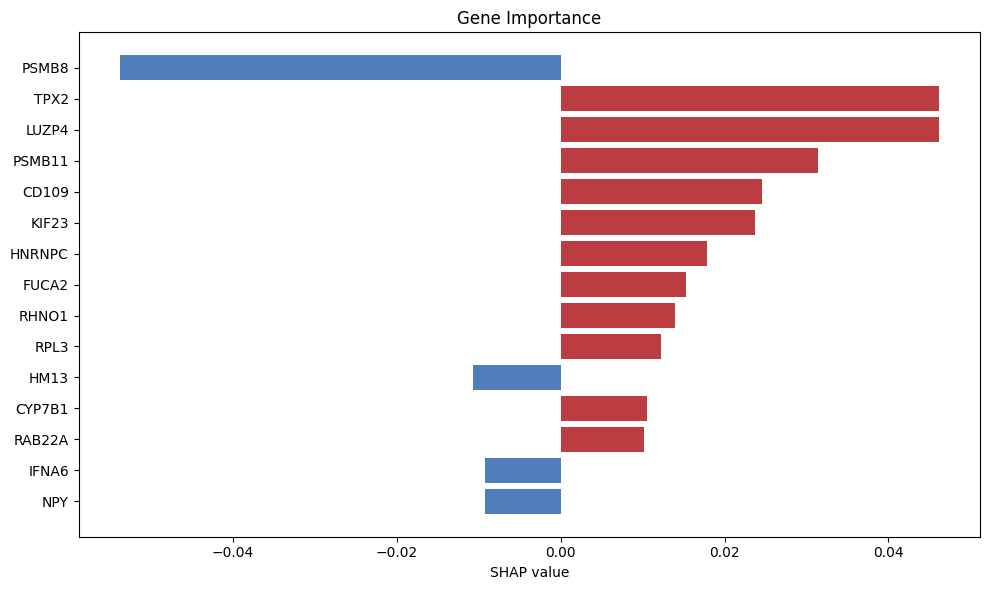

In [23]:
plot_shap_importances(preds.iloc[0]['ShapDictionary'])


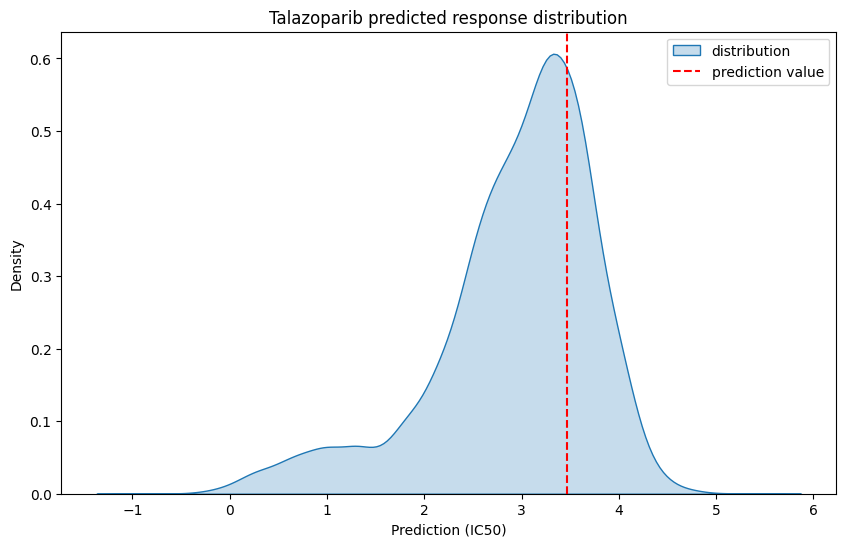

In [24]:
# Plot the distribution for the current drug
plot_distribution(obs['prediction'], drug_distr,drug_name=obs['DrugName'],mode='drug_distr')

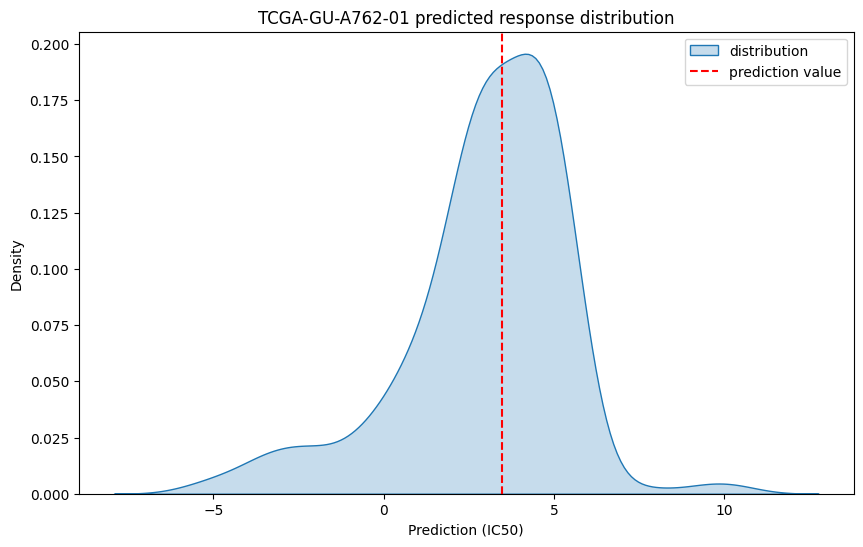

In [25]:
# Plot the distribution for the current drug
plot_distribution(obs['prediction'], cell_distr,cell_name=obs['index'],mode='cell_distr')

# Nearest neighbor in the stranscriptomics space

In [26]:
#assemble the predictions 
ccle_response_neighs = FaissKNN.from_file('/home/fcarli/WebCellHit/webserver_data/local_data/ccle_response_neighs.pkl')
tcga_response_neighs = FaissKNN.from_file('/home/fcarli/WebCellHit/webserver_data/local_data/tcga_response_neighs.pkl')

In [27]:
pivot_tdf = preds[['index','DrugID','prediction']].pivot(index='index',columns='DrugID',values='prediction')

In [28]:
ccle_response_neighs_df = ccle_response_neighs.knn(pivot_tdf,k=1,skip_self=True)
ccle_response_neighs_df.rename({'neighbour_point':'ccle_response_neigh'},axis=1,inplace=True)
tcga_response_neighs_df = tcga_response_neighs.knn(pivot_tdf,k=1,skip_self=True)
tcga_response_neighs_df.rename({'neighbour_point':'tcga_response_neigh'},axis=1,inplace=True)

In [29]:
ccle_response_neighs_df.head(5)

,query_point,ccle_response_neigh,ranking,distance
0,TCGA-05-4390-01,ACH-000785,0,45.620117
1,TCGA-06-0210-02,ACH-000592,0,31.271484
2,TCGA-13-0726-01,ACH-001376,0,43.752930
3,TCGA-13-1498-01,ACH-001632,0,26.296875
4,TCGA-24-1431-01,ACH-000460,0,33.550781


In [30]:
tcga_response_neighs_df.head(5)

,query_point,tcga_response_neigh,ranking,distance
0,TCGA-05-4390-01,TCGA-80-5608-01,0,17.942383
1,TCGA-06-0210-02,TCGA-16-1045-01,0,10.085938
2,TCGA-13-0726-01,TCGA-36-1574-01,0,16.030273
3,TCGA-13-1498-01,TCGA-30-1714-01,0,11.804688
4,TCGA-24-1431-01,TCGA-23-1030-01,0,24.223633


In [31]:
#merge the neighs
response_neighs_df = pd.merge(ccle_response_neighs_df[['query_point','ccle_response_neigh']],tcga_response_neighs_df[['query_point','tcga_response_neigh']],on='query_point',how='inner')
response_neighs_df.head(5)


,query_point,ccle_response_neigh,tcga_response_neigh
0,TCGA-05-4390-01,ACH-000785,TCGA-80-5608-01
1,TCGA-06-0210-02,ACH-000592,TCGA-16-1045-01
2,TCGA-13-0726-01,ACH-001376,TCGA-36-1574-01
3,TCGA-13-1498-01,ACH-001632,TCGA-30-1714-01
4,TCGA-24-1431-01,ACH-000460,TCGA-23-1030-01


In [32]:
ccle_response_annot = add_ccle_metadata(ccle_response_neighs_df['ccle_response_neigh'],metadata_path='/home/fcarli/WebCellHit/data/metadata/Model.csv')
ccle_response_annot.columns = ['ccle_response_neigh','ccle_response_neigh_name','ccle_response_neigh_tissue']
ccle_response_annot.head(5)


,ccle_response_neigh,ccle_response_neigh_name,ccle_response_neigh_tissue
0,ACH-000785,NCI-H2126,Lung
1,ACH-000592,TM-31,CNS/Brain
2,ACH-001376,PACADD-135,Pancreas
3,ACH-001632,PEO4,Ovary/Fallopian Tube
4,ACH-000460,SNU-8,Ovary/Fallopian Tube


In [33]:
tcga_response_annot = add_tcga_metadata(tcga_response_neighs_df['tcga_response_neigh'],metadata_path='/home/fcarli/WebCellHit/data/metadata/tcga_oncotree_data.csv')
tcga_response_annot.columns = ['tcga_response_neigh','tcga_response_neigh_tissue']
tcga_response_annot.head(5)

,tcga_response_neigh,tcga_response_neigh_tissue
0,TCGA-80-5608-01,Lung
1,TCGA-16-1045-01,CNS/Brain
2,TCGA-36-1574-01,Ovary/Fallopian Tube
3,TCGA-30-1714-01,Ovary/Fallopian Tube
4,TCGA-23-1030-01,Ovary/Fallopian Tube


In [34]:
#merge annotations
response_neighs_df = pd.merge(response_neighs_df,ccle_response_annot,left_on='ccle_response_neigh',right_on='ccle_response_neigh',how='inner')
response_neighs_df = pd.merge(response_neighs_df,tcga_response_annot,left_on='tcga_response_neigh',right_on='tcga_response_neigh',how='inner')

#reorder columns
response_neighs_df = response_neighs_df[['query_point','ccle_response_neigh','ccle_response_neigh_name','ccle_response_neigh_tissue','tcga_response_neigh','tcga_response_neigh_tissue']]

response_neighs_df.head(5)

,query_point,ccle_response_neigh,ccle_response_neigh_name,ccle_response_neigh_tissue,tcga_response_neigh,tcga_response_neigh_tissue
0,TCGA-05-4390-01,ACH-000785,NCI-H2126,Lung,TCGA-80-5608-01,Lung
1,TCGA-05-4390-01,ACH-000785,NCI-H2126,Lung,TCGA-80-5608-01,Lung
2,TCGA-06-0210-02,ACH-000592,TM-31,CNS/Brain,TCGA-16-1045-01,CNS/Brain
3,TCGA-13-0726-01,ACH-001376,PACADD-135,Pancreas,TCGA-36-1574-01,Ovary/Fallopian Tube
4,TCGA-13-1498-01,ACH-001632,PEO4,Ovary/Fallopian Tube,TCGA-30-1714-01,Ovary/Fallopian Tube


# Merging everything

In [35]:
final_df = pd.merge(preds,transcr_neighs_df,left_on='index',right_on='query_point',how='inner')
final_df = pd.merge(final_df,response_neighs_df,left_on='index',right_on='query_point',how='inner')
final_df.head(5)

,DrugID,DrugName,index,prediction,std,TopGenes,ShapDictionary,PutativeTarget,QuantileScore,query_point_x,...,ccle_transcr_neigh_name,ccle_transcr_neigh_tissue,tcga_transcr_neigh,tcga_transcr_neigh_tissue,query_point_y,ccle_response_neigh,ccle_response_neigh_name,ccle_response_neigh_tissue,tcga_response_neigh,tcga_response_neigh_tissue
0,1259,Talazoparib,TCGA-GU-A762-01,3.464774,0.313864,"NPY,IFNA6,RAB22A,CYP7B1,HM13,RPL3,RHNO1,FUCA2,...","{'NPY': -0.009232962, 'IFNA6': -0.009275853, '...","PARP1,PARP2",0.346845,TCGA-GU-A762-01,...,SCaBER,Bladder/Urinary Tract,TCGA-FD-A62N-01,Bladder/Urinary Tract,TCGA-GU-A762-01,ACH-000723,YD-10B,Head and Neck,TCGA-JW-A5VG-01,Cervix
1,1259,Talazoparib,TCGA-FS-A1ZS-06,3.249672,0.307231,"FNIP1,RAB22A,FUCA2,CTSA,GSTP1,HNRNPC,RPL3,CD10...","{'FNIP1': 0.011421917, 'RAB22A': 0.011925053, ...","PARP1,PARP2",0.463446,TCGA-FS-A1ZS-06,...,CAS-1,CNS/Brain,TCGA-DX-AB2E-01,Soft Tissue,TCGA-FS-A1ZS-06,ACH-001843,ICC3,Biliary Tract,TCGA-D3-A8GE-06,Skin
2,1259,Talazoparib,TCGA-BH-A8FZ-01,3.630200,0.267536,"UBE2C,RAB22A,POLR2A,RPL3,FUCA2,RAB36,GSTP1,HNR...","{'UBE2C': 0.011801495, 'RAB22A': 0.014965078, ...","PARP1,PARP2",0.256921,TCGA-BH-A8FZ-01,...,MDA-MB-468,Breast,TCGA-A2-A4RY-01,Breast,TCGA-BH-A8FZ-01,ACH-000017,SK-BR-3,Breast,TCGA-A8-A08X-01,Breast
3,1259,Talazoparib,TCGA-BH-A8FZ-01,3.630200,0.267536,"UBE2C,RAB22A,POLR2A,RPL3,FUCA2,RAB36,GSTP1,HNR...","{'UBE2C': 0.011801495, 'RAB22A': 0.014965078, ...","PARP1,PARP2",0.256921,TCGA-BH-A8FZ-01,...,MDA-MB-468,Breast,TCGA-A2-A4RY-01,Breast,TCGA-BH-A8FZ-01,ACH-000017,SK-BR-3,Breast,TCGA-A8-A08X-01,Breast
4,1259,Talazoparib,TCGA-CR-7376-01,3.030244,0.361019,"ST8SIA5,RAB22A,PSMB8,UBE2C,CYP7B1,FUCA2,RPL3,N...","{'ST8SIA5': 0.010179712, 'RAB22A': 0.011249597...","PARP1,PARP2",0.528148,TCGA-CR-7376-01,...,BICR 16,Head and Neck,TCGA-CR-6492-01,Head and Neck,TCGA-CR-7376-01,ACH-000606,PE/CA-PJ34 (clone C12),Head and Neck,TCGA-CR-6492-01,Head and Neck


In [37]:
#drop the query_point columns
final_df.drop(columns=['query_point_x','query_point_y'],inplace=True)
final_df.head(5)

,DrugID,DrugName,index,prediction,std,TopGenes,ShapDictionary,PutativeTarget,QuantileScore,ccle_transcr_neigh,ccle_transcr_neigh_name,ccle_transcr_neigh_tissue,tcga_transcr_neigh,tcga_transcr_neigh_tissue,ccle_response_neigh,ccle_response_neigh_name,ccle_response_neigh_tissue,tcga_response_neigh,tcga_response_neigh_tissue
0,1259,Talazoparib,TCGA-GU-A762-01,3.464774,0.313864,"NPY,IFNA6,RAB22A,CYP7B1,HM13,RPL3,RHNO1,FUCA2,...","{'NPY': -0.009232962, 'IFNA6': -0.009275853, '...","PARP1,PARP2",0.346845,ACH-000839,SCaBER,Bladder/Urinary Tract,TCGA-FD-A62N-01,Bladder/Urinary Tract,ACH-000723,YD-10B,Head and Neck,TCGA-JW-A5VG-01,Cervix
1,1259,Talazoparib,TCGA-FS-A1ZS-06,3.249672,0.307231,"FNIP1,RAB22A,FUCA2,CTSA,GSTP1,HNRNPC,RPL3,CD10...","{'FNIP1': 0.011421917, 'RAB22A': 0.011925053, ...","PARP1,PARP2",0.463446,ACH-000464,CAS-1,CNS/Brain,TCGA-DX-AB2E-01,Soft Tissue,ACH-001843,ICC3,Biliary Tract,TCGA-D3-A8GE-06,Skin
2,1259,Talazoparib,TCGA-BH-A8FZ-01,3.630200,0.267536,"UBE2C,RAB22A,POLR2A,RPL3,FUCA2,RAB36,GSTP1,HNR...","{'UBE2C': 0.011801495, 'RAB22A': 0.014965078, ...","PARP1,PARP2",0.256921,ACH-000849,MDA-MB-468,Breast,TCGA-A2-A4RY-01,Breast,ACH-000017,SK-BR-3,Breast,TCGA-A8-A08X-01,Breast
3,1259,Talazoparib,TCGA-BH-A8FZ-01,3.630200,0.267536,"UBE2C,RAB22A,POLR2A,RPL3,FUCA2,RAB36,GSTP1,HNR...","{'UBE2C': 0.011801495, 'RAB22A': 0.014965078, ...","PARP1,PARP2",0.256921,ACH-000849,MDA-MB-468,Breast,TCGA-A2-A4RY-01,Breast,ACH-000017,SK-BR-3,Breast,TCGA-A8-A08X-01,Breast
4,1259,Talazoparib,TCGA-CR-7376-01,3.030244,0.361019,"ST8SIA5,RAB22A,PSMB8,UBE2C,CYP7B1,FUCA2,RPL3,N...","{'ST8SIA5': 0.010179712, 'RAB22A': 0.011249597...","PARP1,PARP2",0.528148,ACH-000503,BICR 16,Head and Neck,TCGA-CR-6492-01,Head and Neck,ACH-000606,PE/CA-PJ34 (clone C12),Head and Neck,TCGA-CR-6492-01,Head and Neck


# Heatmap data

In [18]:
heatmap_data =preds[['index','prediction','DrugName']].pivot(index='index',columns='DrugName',values='prediction')
# Subtract median from each drug column using the median_mapper
for drug in heatmap_data.columns:
    heatmap_data[drug] = heatmap_data[drug] - median_mapper[drug]

heatmap_data

DrugName,AZD5363,Elephantin,OF-1,Romidepsin,Talazoparib
index,,,,,
TCGA-09-0369-01,0.167365,0.565500,-0.167316,0.340975,-0.095460
TCGA-13-0923-01,0.268458,0.399494,-0.248631,0.729334,0.561953
TCGA-14-1825-01,-0.471006,0.792970,0.178391,-0.095262,-0.168433
TCGA-19-2625-01,0.468534,0.881608,0.015149,0.020657,-0.033324
TCGA-24-1105-01,0.356550,0.859675,0.097500,1.052572,0.605744
...,...,...,...,...,...
TCGA-YG-AA3N-01,0.251955,0.059199,0.189171,-0.232100,-0.062949
TCGA-ZB-A96K-01,-0.190610,0.542498,0.296653,0.414069,-0.421864
TCGA-ZF-A9R7-01,0.312419,0.288294,0.089963,0.253302,0.188417
